In [17]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import random as rnd
%pip install scikit-image -q
from skimage.util import view_as_windows
from scipy.ndimage import median_filter

Note: you may need to restart the kernel to use updated packages.


In [18]:
%load_ext autoreload
%autoreload 

import os
import sys
# add path ../src to sys
sys.path.append(os.path.join(os.getcwd(), '../src'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from Blockfy import BlockifyImage
from BasisGenerator import BasisGenerator

In [20]:
P,Q = 8,8
bg = BasisGenerator(P,Q, uv_orientation=True)

basisMatrix = bg.generate_basis_matrix()

## Create k-folds for training and validation

In [21]:
S = 30
m = S//6 # test-training split 80-20
M = 20 # number of training samples
img_path = '../assets/fishing_boat/fishing_boat.bmp'

In [22]:
bi = BlockifyImage(img_path, (P,Q), P)
bi.generate_blocks()
corrpt_blocks = bi.generate_corrupted_blocks(sensed_pixels=S)

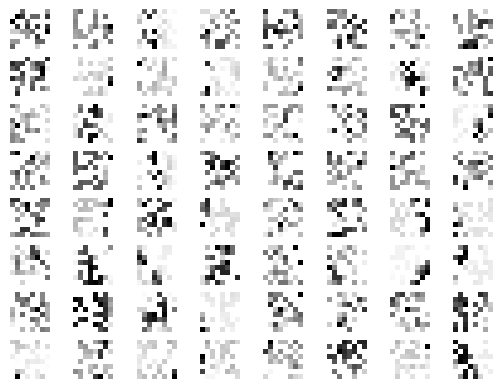

In [23]:
for i in range(P*Q):
    plt.subplot(P,Q,i+1)
    plt.imshow(corrpt_blocks[i], cmap='gray')
    plt.axis('off')

In [24]:
rkf = RepeatedKFold(n_splits=m, n_repeats=M)
for i in range(P*Q):
    chip_flat = corrpt_blocks[i].flatten()
    good_pixels_idx = np.where(~np.isnan(chip_flat))[0]
    good_pixels_idx = good_pixels_idx.astype(int)
    chip_flat = chip_flat[good_pixels_idx]
    bm_chip = basisMatrix[good_pixels_idx]
    
    rkf.get_n_splits(bm_chip, chip_flat)
    train_index, test_index = next(iter(rkf.split(bm_chip)))
    
    alpha = np.logspace(-6,6,20)
    mse_chip = []
    
    rec_chips = []
    corrup_chips = []
    mse_values = []
    
    for j,a in enumerate(alpha):
        lasso = Lasso(alpha=a, fit_intercept=False)
        lasso.fit(bm_chip[train_index], chip_flat[train_index])
        
        recov_chip = np.sum(
            lasso.coef_.reshape(-1,1,1) * basisMatrix.T.reshape(-1,P,P), axis=0
        )
        
        masked_corrupt_chip = np.full_like(corrpt_blocks[i], np.nan)
        for idx in good_pixels_idx[test_index]:  # Use indices array to map back to original image positions
            masked_corrupt_chip.flat[idx] = corrpt_blocks[i].flat[idx]
            
        masked_reconstruct_chip = np.full_like(corrpt_blocks[i], np.nan)
        for idx in good_pixels_idx[test_index]:  # Use indices array to map back to original image positions
            masked_reconstruct_chip.flat[idx] = recov_chip.flat[idx]
        
        rec_chips.append(masked_reconstruct_chip)
        corrup_chips.append(masked_corrupt_chip)
        
        # Calculate MSE
        valid_pixels = ~np.isnan(masked_corrupt_chip) & ~np.isnan(masked_reconstruct_chip)
        
        if np.any(valid_pixels):
            mse = mean_squared_error(masked_corrupt_chip[valid_pixels], masked_reconstruct_chip[valid_pixels])
            mse_values.append(mse)
        else:
            mse_values.append(np.nan)
            print('Warning: No valid pixels in MSE calculation')
    
    # get index of minimum MSE
    min_mse_idx = np.nanargmin(mse_values)
    min_mse_alpha = alpha[min_mse_idx]
    
    print(f'Block {i+1} - Minimum MSE: {mse_values[min_mse_idx]}, Alpha: {min_mse_alpha}')

Block 1 - Minimum MSE: 0.5427362656984531, Alpha: 0.0014384498882876629
Block 2 - Minimum MSE: 51.5423886678882, Alpha: 0.4832930238571752
Block 3 - Minimum MSE: 376.4343718796333, Alpha: 0.4832930238571752
Block 4 - Minimum MSE: 4.221362883655471, Alpha: 1e-06
Block 5 - Minimum MSE: 1.7229744731856858, Alpha: 0.026366508987303555
Block 6 - Minimum MSE: 4.756038371786645, Alpha: 0.11288378916846883
Block 7 - Minimum MSE: 1.003346536947916, Alpha: 0.11288378916846883
Block 8 - Minimum MSE: 0.6513541861326982, Alpha: 0.00615848211066026
Block 9 - Minimum MSE: 0.34554403522957045, Alpha: 0.026366508987303555
Block 10 - Minimum MSE: 1.8910584665177022, Alpha: 0.0003359818286283781
Block 11 - Minimum MSE: 43.79909260960621, Alpha: 0.4832930238571752
Block 12 - Minimum MSE: 396.4347492422144, Alpha: 0.0014384498882876629
Block 13 - Minimum MSE: 8.709257185983917, Alpha: 0.00615848211066026
Block 14 - Minimum MSE: 18.81662266672836, Alpha: 0.0014384498882876629
Block 15 - Minimum MSE: 915.660

## Function streamline best alpha selection for lasso each chip

In [27]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from Blockfy import BlockifyImage
from BasisGenerator import BasisGenerator


class LassoAlphaOptimizer:
    """A class for optimizing alpha parameters for Lasso regression on image blocks.

    This class provides functionality to:
    1. Optimize alpha parameters for Lasso regression on corrupted image blocks
    2. Return the best alpha parameters for each block

    Attributes:
        S (int): Number of sensed pixels per block
        M (int): Number of training samples
        test_train_split (float): Ratio of test to training data (e.g., 0.2 for 80-20 split)
        P (int): Height of the basis chips
        Q (int): Width of the basis chips
        basis_generator (BasisGenerator): Instance of BasisGenerator for generating basis matrices
        blockifier (BlockifyImage): Instance of BlockifyImage for processing image blocks
    """

    def __init__(self, S: int, M: int, test_train_split: float = 0.2, P: int = 8, Q: int = 8):
        """Initialize the LassoAlphaOptimizer instance.

        Args:
            S (int): Number of sensed pixels per block
            M (int): Number of training samples
            test_train_split (float): Ratio of test to training data (default: 0.2)
            P (int): Height of the basis chips (default: 8)
            Q (int): Width of the basis chips (default: 8)
        """
        self.S = S
        self.M = M
        self.test_train_split = test_train_split
        self.P = P
        self.Q = Q
        self.basis_generator = BasisGenerator(P, Q, uv_orientation=True)
        self.blockifier = None

    def optimize_alphas(self, img_path: str) -> np.ndarray:
        """Optimize alpha parameters for Lasso regression on corrupted image blocks.

        Args:
            img_path (str): Path to the input image file

        Returns:
            numpy.ndarray: Array of best alpha parameters for each block
        """
        # Initialize BlockifyImage
        self.blockifier = BlockifyImage(img_path, (self.P, self.Q), self.P)
        self.blockifier.generate_blocks()
        corrupted_blocks = self.blockifier.generate_corrupted_blocks(sensed_pixels=self.S)

        # Generate basis matrix
        basis_matrix = self.basis_generator.generate_basis_matrix()

        # Initialize RepeatedKFold
        m = int(self.S * self.test_train_split)  # Number of test samples
        rkf = RepeatedKFold(n_splits=m, n_repeats=self.M)

        # Array to store best alphas for each block
        best_alphas = np.zeros(self.P * self.Q)

        # Precompute alpha values
        alpha_values = np.logspace(-6, 6, 20)

        # Iterate over each block
        for i in range(self.P * self.Q):
            chip_flat = corrupted_blocks[i].flatten()
            good_pixels_idx = np.where(~np.isnan(chip_flat))[0].astype(int)
            chip_flat = chip_flat[good_pixels_idx]
            bm_chip = basis_matrix[good_pixels_idx]

            # Initialize MSE values
            mse_values = np.zeros(len(alpha_values))

            # Perform cross-validation
            for j, a in enumerate(alpha_values):
                mse_fold = []
                for train_index, test_index in rkf.split(bm_chip):
                    lasso = Lasso(alpha=a, fit_intercept=False, max_iter=5000)
                    lasso.fit(bm_chip[train_index], chip_flat[train_index])

                    # Reconstruct the chip
                    recov_chip = np.sum(
                        lasso.coef_.reshape(-1, 1, 1) * basis_matrix.T.reshape(-1, self.P, self.P), axis=0
                    )

                    # Mask the reconstructed and corrupted chips
                    masked_corrupt_chip = np.full_like(corrupted_blocks[i], np.nan)
                    masked_corrupt_chip.flat[good_pixels_idx[test_index]] = corrupted_blocks[i].flat[good_pixels_idx[test_index]]

                    masked_reconstruct_chip = np.full_like(corrupted_blocks[i], np.nan)
                    masked_reconstruct_chip.flat[good_pixels_idx[test_index]] = recov_chip.flat[good_pixels_idx[test_index]]

                    # Calculate MSE
                    valid_pixels = ~np.isnan(masked_corrupt_chip) & ~np.isnan(masked_reconstruct_chip)
                    if np.any(valid_pixels):
                        mse = mean_squared_error(
                            masked_corrupt_chip[valid_pixels], masked_reconstruct_chip[valid_pixels]
                        )
                        mse_fold.append(mse)
                    else:
                        mse_fold.append(np.nan)

                # Average MSE across folds
                mse_values[j] = np.nanmean(mse_fold)

            # Find the best alpha
            min_mse_idx = np.nanargmin(mse_values)
            best_alphas[i] = alpha_values[min_mse_idx]

        return best_alphas

In [28]:
# Initialize the LassoAlphaOptimizer
optimizer = LassoAlphaOptimizer(S=30, M=20, test_train_split=0.2)

# Optimize alphas for an image
img_path = '../assets/fishing_boat/fishing_boat.bmp'
best_alphas = optimizer.optimize_alphas(img_path)

# Print the best alphas
print("Best Alphas for Each Block:", best_alphas)

Best Alphas for Each Block: [0.11288379 0.11288379 0.00615848 0.02636651 0.11288379 0.02636651
 0.02636651 0.00615848 0.02636651 0.11288379 0.00143845 0.11288379
 0.00615848 0.11288379 0.00615848 0.00143845 0.00143845 0.02636651
 0.11288379 0.11288379 0.00615848 0.00143845 0.00143845 0.00143845
 0.00143845 0.11288379 0.48329302 0.00143845 0.00615848 0.02636651
 0.00143845 0.02636651 0.00143845 0.48329302 0.00615848 0.00615848
 0.00143845 0.11288379 0.00615848 0.00143845 0.00143845 0.48329302
 0.00615848 0.00143845 0.00143845 0.00143845 0.00615848 0.00615848
 0.00143845 0.02636651 0.00143845 0.00143845 0.00143845 0.00143845
 0.02636651 0.00143845 0.00143845 0.00143845 0.48329302 0.11288379
 0.00615848 0.00143845 0.00143845 0.48329302]


In [29]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from joblib import Parallel, delayed  # For parallel processing
from Blockfy import BlockifyImage
from BasisGenerator import BasisGenerator


class LassoAlphaOptimizer:
    """A class for optimizing alpha parameters for Lasso regression on image blocks."""

    def __init__(self, S: int, M: int, test_train_split: float = 0.2, P: int = 8, Q: int = 8):
        """Initialize the LassoAlphaOptimizer instance."""
        self.S = S
        self.M = M
        self.test_train_split = test_train_split
        self.P = P
        self.Q = Q
        self.basis_generator = BasisGenerator(P, Q, uv_orientation=True)
        self.blockifier = None

    def _process_block(self, corrupted_block, basis_matrix, alpha_values, rkf):
        """Process a single block to find the best alpha."""
        chip_flat = corrupted_block.flatten()
        good_pixels_idx = np.where(~np.isnan(chip_flat))[0].astype(int)
        chip_flat = chip_flat[good_pixels_idx]
        bm_chip = basis_matrix[good_pixels_idx]

        mse_values = np.zeros(len(alpha_values))

        for j, a in enumerate(alpha_values):
            mse_fold = []
            for train_index, test_index in rkf.split(bm_chip):
                lasso = Lasso(alpha=a, fit_intercept=False, max_iter=5000, tol=1e-4)
                lasso.fit(bm_chip[train_index], chip_flat[train_index])

                # Reconstruct the chip
                recov_chip = np.dot(basis_matrix, lasso.coef_).reshape(self.P, self.Q)

                # Mask the reconstructed and corrupted chips
                masked_corrupt_chip = np.full_like(corrupted_block, np.nan)
                masked_corrupt_chip.flat[good_pixels_idx[test_index]] = corrupted_block.flat[good_pixels_idx[test_index]]

                masked_reconstruct_chip = np.full_like(corrupted_block, np.nan)
                masked_reconstruct_chip.flat[good_pixels_idx[test_index]] = recov_chip.flat[good_pixels_idx[test_index]]

                # Calculate MSE
                valid_pixels = ~np.isnan(masked_corrupt_chip) & ~np.isnan(masked_reconstruct_chip)
                if np.any(valid_pixels):
                    mse = mean_squared_error(
                        masked_corrupt_chip[valid_pixels], masked_reconstruct_chip[valid_pixels]
                    )
                    mse_fold.append(mse)
                else:
                    mse_fold.append(np.nan)

            # Average MSE across folds
            mse_values[j] = np.nanmean(mse_fold)

        # Find the best alpha
        min_mse_idx = np.nanargmin(mse_values)
        return alpha_values[min_mse_idx]

    def optimize_alphas(self, img_path: str) -> np.ndarray:
        """Optimize alpha parameters for Lasso regression on corrupted image blocks."""
        # Initialize BlockifyImage
        self.blockifier = BlockifyImage(img_path, (self.P, self.Q), self.P)
        self.blockifier.generate_blocks()
        corrupted_blocks = self.blockifier.generate_corrupted_blocks(sensed_pixels=self.S)

        # Generate basis matrix
        basis_matrix = self.basis_generator.generate_basis_matrix()

        # Initialize RepeatedKFold
        m = int(self.S * self.test_train_split)  # Number of test samples
        rkf = RepeatedKFold(n_splits=m, n_repeats=self.M)

        # Precompute alpha values
        alpha_values = np.logspace(-6, 6, 20)

        # Process blocks in parallel
        best_alphas = Parallel(n_jobs=-1)(
            delayed(self._process_block)(corrupted_blocks[i], basis_matrix, alpha_values, rkf)
            for i in range(self.P * self.Q)
        )

        return np.array(best_alphas)

In [30]:
# Initialize the LassoAlphaOptimizer
optimizer = LassoAlphaOptimizer(S=30, M=20, test_train_split=0.2)

# Optimize alphas for an image
img_path = '../assets/fishing_boat/fishing_boat.bmp'
best_alphas = optimizer.optimize_alphas(img_path)

# Print the best alphas
print("Best Alphas for Each Block:", best_alphas)

Best Alphas for Each Block: [3.35981829e-04 1.12883789e-01 6.15848211e-03 1.12883789e-01
 2.63665090e-02 2.63665090e-02 1.12883789e-01 1.43844989e-03
 1.12883789e-01 1.43844989e-03 6.15848211e-03 4.83293024e-01
 1.12883789e-01 1.43844989e-03 2.63665090e-02 6.15848211e-03
 6.15848211e-03 4.83293024e-01 1.12883789e-01 1.12883789e-01
 1.12883789e-01 6.15848211e-03 1.12883789e-01 1.43844989e-03
 6.15848211e-03 1.12883789e-01 1.12883789e-01 1.12883789e-01
 1.43844989e-03 2.63665090e-02 1.12883789e-01 2.63665090e-02
 1.43844989e-03 1.43844989e-03 6.15848211e-03 1.12883789e-01
 6.15848211e-03 6.15848211e-03 1.12883789e-01 2.63665090e-02
 1.12883789e-01 2.06913808e+00 1.43844989e-03 6.15848211e-03
 1.43844989e-03 1.12883789e-01 1.43844989e-03 1.43844989e-03
 1.43844989e-03 3.35981829e-04 1.43844989e-03 1.43844989e-03
 1.12883789e-01 1.12883789e-01 6.15848211e-03 1.43844989e-03
 6.15848211e-03 1.12883789e-01 1.43844989e-03 2.63665090e-02
 6.15848211e-03 1.43844989e-03 6.15848211e-03 4.83293024e